<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D3_NetworkCausality/W3D3_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy 2020 -- Week 3 Day 3, Tutorial 4

# Causality Day: Instrumental Variables


# Overall tutorial objectives

This is our final tutorial on our day of examining causality. Below is the high level outline of what we've covered today, with the sections we will focus on in this notebook in bold:

1.   Master definitions of causality
2.   Understand that estimating causality is possible
3.   Learn 5 different methods and understand when they fail
    1. perturbations
    2. correlations
    3. simultaneous fitting/regression
    4. Granger causality
    5. **instrumental variables**

### Notebook 4 Objectives

In tutorial 3 we saw that even more sophisticated techniques such as simultaneous fitting and Granger causality fail to capture causality in the presence of omitted variable bias. So what techniques are there for us to obtain valid causal measurements when we can't perturb the system? Here we will:

- learn about **instrumental variables,** a method that does not require experimental data for valid causal analysis
- explore benefits of instrumental variable analysis and limitations
    - addresses **omitted variable bias** seen in regression
    - less efficient in terms of sample size than other techniques
    - requires a particular form of randomness in the system in order for causal effects to be identified

# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso


In [2]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

In [3]:
#@title Helper Functions
def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x.
    
    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def logit(x):
    """
    
    Applies the logit (inverse sigmoid) transformation
    
    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with logit nonlinearity applied
    """
    return np.log(x/(1-x))

def create_connectivity(n_neurons, random_state=42):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0,1], size=(n_neurons, n_neurons), p=[0.9, 0.1])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals , _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0]) 

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A

def see_neurons(A, ax):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    n = len(A)
    ax.set_aspect('equal')
    thetas = np.linspace(0,np.pi*2,n,endpoint=False )
    x,y = np.cos(thetas),np.sin(thetas),
    ax.scatter(x,y,c='k',s=150)
    for i in range(n):
        for j in range(n):
            if A[i,j]>0:
                ax.arrow(x[i],y[i],x[j]-x[i],y[j]-y[i],color='k',alpha=A[i,j],head_width=.15,
                        width = A[i,j]/25,shape='right', length_includes_head=True)
    ax.axis('off')


def simulate_neurons(A, timesteps, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility
        
    Returns:
        - X has shape (n_neurons, timeteps).
    """
    np.random.seed(random_state)

    
    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps-1):
        # solution
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t+1] = sigmoid(A.dot(X[:,t]) + epsilon)

        assert epsilon.shape == (n_neurons,)
    return X


def correlation_for_all_neurons(X):
  """Computes the connectivity matrix for the all neurons using correlations

    Args:
        X: the matrix of activities

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
        """
  n_neurons = len(X)
  S = np.concatenate([X[:, 1:], X[:, :-1]], axis=0)
  R = np.corrcoef(S)[:n_neurons, n_neurons:] 
  return R


def get_sys_corr(n_neurons, timesteps, random_state=42, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and R.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        neuron_idx (int): optionally provide a neuron idx to slice out

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    
    A = create_connectivity(n_neurons,random_state)
    X = simulate_neurons(A, timesteps)

    R = correlation_for_all_neurons(X)

    return np.corrcoef(A.flatten(), R.flatten())[0,1]


def get_regression_estimate(X, neuron_idx=None):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    if neuron_idx is None:
        Y = X[:, 1:].transpose()
    else:
        Y = X[[neuron_idx], 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # fit multioutput regression

    ############################################################################
    ## Insert your code here to fit a multioutput regressor with Lasso.
    ##
    ## Hyperparameters:
    ##     alpha = 0.01
    ##     fit_intercept = False
    ##
    ## Function Hints:
    ##     lasso regression -> Lasso()
    ############################################################################
    # stub for student
    # regression = MultiOutputRegressor("""your code here""", n_jobs=-1)    

    # solution
    regression = MultiOutputRegressor(Lasso(fit_intercept=False, alpha=0.01), n_jobs=-1)    

    regression.fit(W,Y)

    if neuron_idx is None:
        V = np.zeros((n_neurons, n_neurons))
        for i, estimator in enumerate(regression.estimators_):
            V[i, :] = estimator.coef_
    else:
        V = regression.estimators_[0].coef_

    return V
    

def get_regression_corr(n_neurons, timesteps, random_state, observed_ratio, regression_args, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        observed_ratio (float): the proportion of n_neurons observed, must be betweem 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    A = create_connectivity(n_neurons, random_state)
    X = simulate_neurons(A, timesteps)

    sel_idx = np.clip(int(n_neurons*observed_ratio), 1, n_neurons)

    sel_X = X[:sel_idx, :]
    sel_A = A[:sel_idx, :sel_idx]

    sel_V = get_regression_estimate(sel_X, neuron_idx=neuron_idx)
    if neuron_idx is None:
        return np.corrcoef(sel_A.flatten(), sel_V.flatten())[1,0]
    else:
        return np.corrcoef(sel_A[neuron_idx, :], sel_V)[1,0]


def compare_iv_estimate_to_regression(observed_ratio):
  """
  A wrapper function to compare IV and Regressor performance as a function of observed neurons

  Args:
        observed_ratio(list): a list of different observed ratios (out of the whole system)
  """
  
  #Let's compare IV estimates to our regression estimates, uncomment the code below

  reg_corrs = np.zeros((len(observed_ratio),))
  iv_corrs = np.zeros((len(observed_ratio),))
  for j, ratio in enumerate(observed_ratio):
      print(ratio)
      sel_idx = int(ratio * n_neurons)

      sel_X = X[:sel_idx, :]
      sel_Z = X[:sel_idx, :]
      sel_A = A[:sel_idx, :sel_idx]

      sel_reg_V = get_regression_estimate(sel_X)
      reg_corrs[j] = np.corrcoef(sel_A.flatten(), sel_reg_V.flatten())[1,0]

      sel_iv_V = get_iv_estimate(sel_X, sel_Z)
      iv_corrs[j] = np.corrcoef(sel_A.flatten(), sel_iv_V.flatten())[1,0]
  
  # Plotting IV vs lasso performance
  plt.plot(observed_ratio, reg_corrs)
  plt.plot(observed_ratio, iv_corrs)
  plt.xlim([1, 0])
  plt.title("IV and lasso performance as a function of observed neuron ratio")

# Instrumental Variables

Video available at https://youtu.be/HxbrutRm5e8


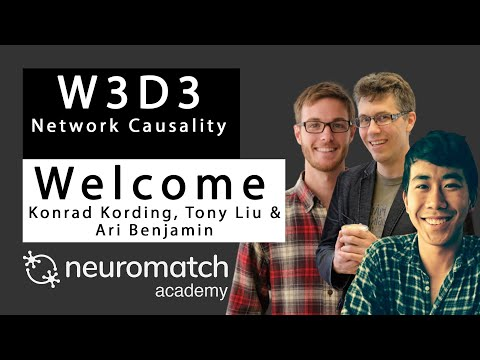

In [4]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="HxbrutRm5e8", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

If there is randomness naturally occurring in the system *that we can observe*, this in effect becomes the perturbations we can use to recover causal effects. This is called an **instrumental variable**. At high level, an instrumental variable must


1.   be observable
2.   effect a covariate you care about
3.   **not** effect the outcome, except through the covariate


It's rare to find these things in the wild, but when you do it's very powerful. 

### A non-neuro example of an IV
A classic example is estimating the effect of smoking cigarettes while pregnant on the birth weight of the infant. There is a (negative) correlation, but is it causal? Unfortunately many confounds affect both birth weight and smoking. Wealth is a big one.

Instead of controlling for everything imaginable, one can find an IV. Here the instrumental variable is **state taxes on tobacco**. These


1.   Are observable
2.   Affect tobacco consumption
3.   Don't affect birth weight except through tobacco

By using the power of IV techniques, you can determine the causal effect without exhaustively controlling for everything.





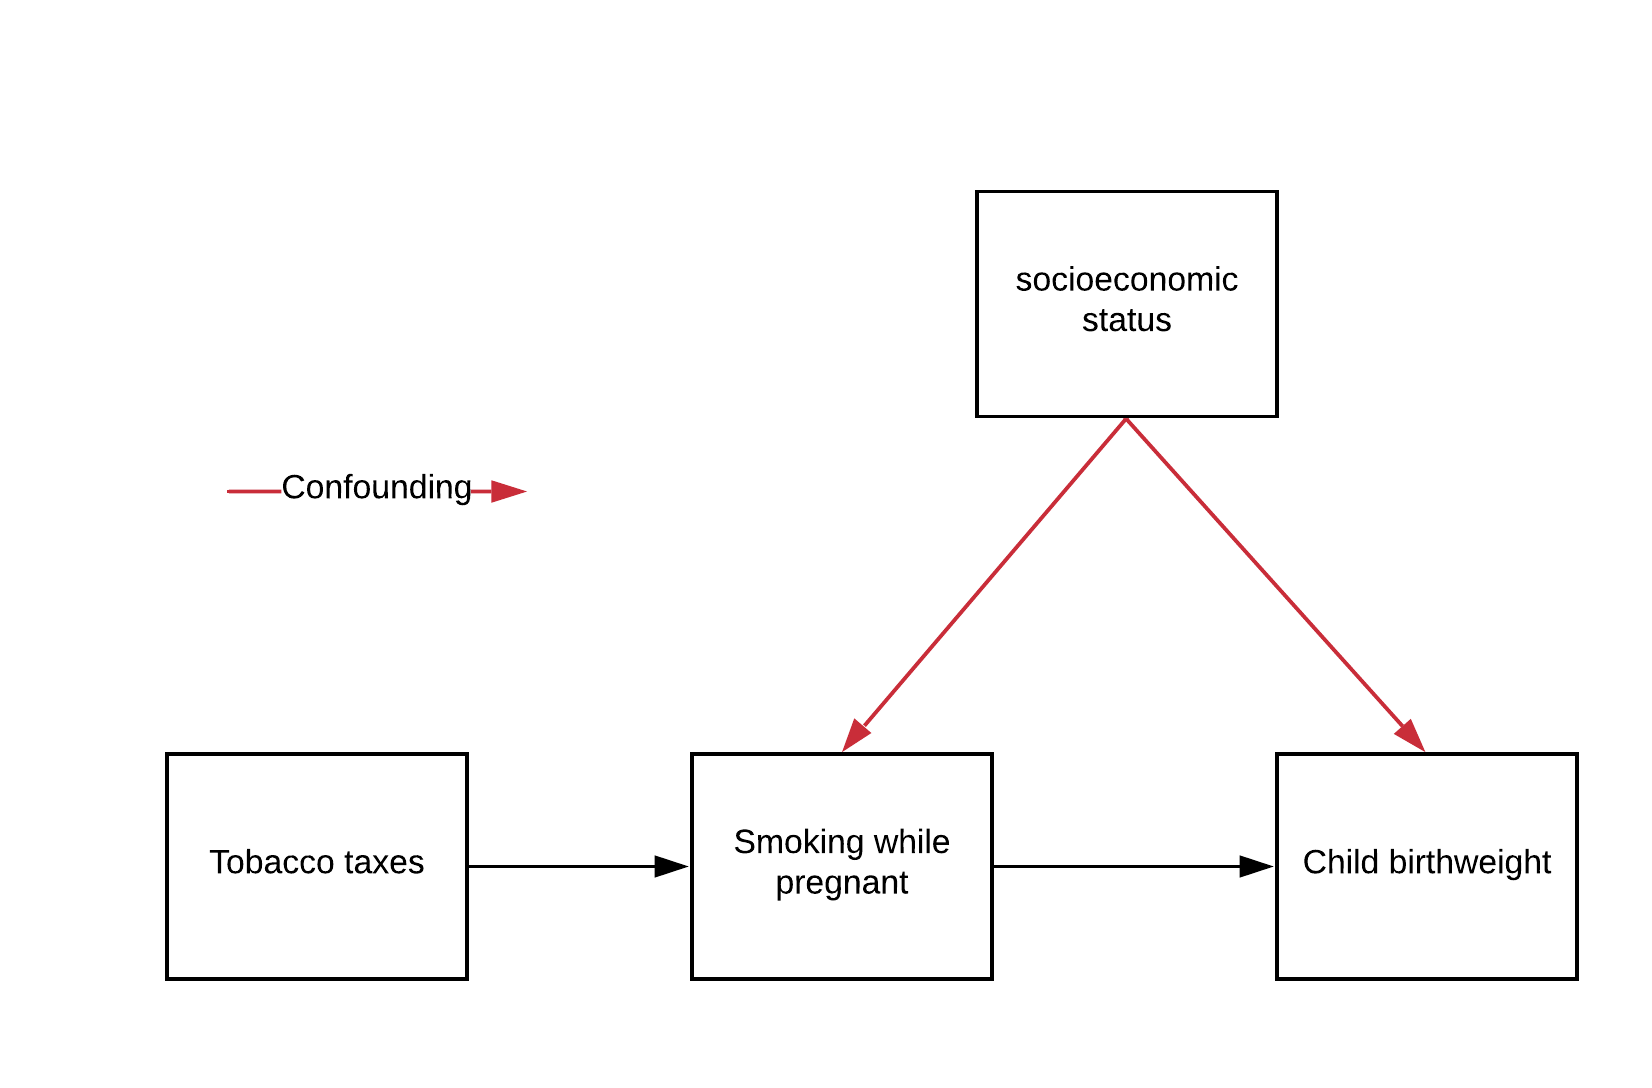


## The math of IV
Say we have the system we have been simulating, except with an additional variable $z$. This will be our instrumental variable. $z$ satistfies the 3 criteria above.

We treat $z$ as a source of noise in the dynamics of our neurons:

$$
\vec{x}_{t+1} = \theta(A\vec{x}_t + \eta z_{t+1} + \epsilon_t)
$$

- $\eta$ is what we'll call the "strength" of our IV
- $\vec{z}_t$ is a random binary variable, $\vec{z}_t \sim Bernoulli(0.5)$

### What could be $z$, biologically?

Imagine $z$ to be some injected current through an *in vivo* patch clamp. It affects each neuron individually, and only affects dynamics through that neuron.

The cool thing about IV is that you don't have to control $z$ yourself - it can be observed. So if you mess up your wiring and accidentally connect the injected voltage to an AM radio, no worries. As long as you can observe the signal the method will work.

## Exercise 1: Simulate a system with IV

Edit your old function that simulates the neural system, but this time make the update rule include the effect of the instrumental variable $z$.

In [5]:
def simulate_neurons_iv(n_neurons, timesteps, eta, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        eta (float): the strength of the instrument
        random_state (int): seed for reproducibility
        
    Returns:
        The tuple (A,X,Z) of the connectivity matrix, simulated system, and instruments.
        - A has shape (n_neurons, n_neurons)
        - X has shape (n_neurons, timesteps)
        - Z has shape (n_neurons, timesteps)
    """
    np.random.seed(random_state)
    A = create_connectivity(n_neurons, random_state)

    X = np.zeros((n_neurons, timesteps))
    Z = np.random.choice([0,1], size=(n_neurons, timesteps))
    for t in range(timesteps-1):

      ############################################################################
      ## Insert your code here to adjust the update rule to include the 
      ## instrumental variable.
      ##  We've already created Z for you. (We need to return it to regress on it).
      ##  Your task is to slice it appropriately. Don't forget eta.
      ## Fill out function and remove
      raise NotImplementedError('Complete simulate_neurons_iv function')
      ############################################################################
      
      IV_on_this_timestep = ...
      
      X[:, t+1] = sigmoid(A.dot(X[:,t]) + IV_on_this_timestep + np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons)))

    return A, X, Z

# Uncomment once you have completed the function: let's visualize the dynamics
# timesteps = 5000 # Simulate for 5000 timesteps.
# n_neurons = 100 # the size of our system
# eta = 2 # the strength of our instrument, higher is stronger
# # Simulate our dynamical system for the given amount of time
# A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta)
# plt.imshow(X[:, :10],aspect='auto')
# plt.colorbar()
# plt.ylabel("Neuron", fontsize=15)
# plt.xlabel("Timestep", fontsize=15);
# plt.title("Our dynamical system with an IV")

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D3_NetworkCausality/solutions/W3D3_Tutorial4_Solution_5fef5168.py)

*Example output:*

<img alt='Solution hint' align='left' width=491 height=407 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D3_NetworkCausality/static/W3D3_Tutorial4_Solution_5fef5168_0.png>



# Estimation of IV using two-stage least squares 


Video available at https://youtu.be/DbA1RVN1ocY


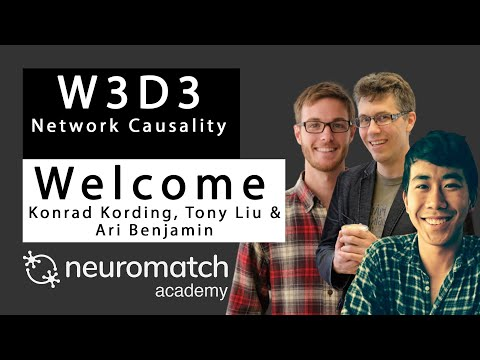

In [7]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="DbA1RVN1ocY", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


- Stage 1: Regress $x_t$ on $z_t$ to obtain $\hat{x}_t$:

$$
\hat{X} = \hat{\eta} Z 
$$


- Stage 2: Regress $\hat{x}_t$ on $x_{t+1}$ to obtain an estimate $V$ of $A$:

$$
Y = X_{1:} \text{, as before}
$$


$$
\hat{Y} = V \hat{X}_{:-1}
$$

## Exercise 2: Compute the IV estimate

Please implement the above equations in the following code skeleton. We will use ``MultiOutputRegressor`` from scikit-learn.

In [8]:
def get_iv_estimate(X,Z):
    """
    Estimates the connectivity matrix from 2-stage least squares regression 
    using an instrument

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        Z (np.ndarray): our observed instruments of shape (n_neurons, timesteps)

    Returns:
        V (np.ndarray): the estimated connectivity matrix
    """
    n_neurons = X.shape[0]
    # stage 1: regress X on Z
    stage1 = MultiOutputRegressor(LinearRegression(fit_intercept=True), n_jobs=-1)
    stage1.fit(Z.transpose(), X.transpose())
    X_hat = stage1.predict(Z.transpose())

    Y = X[:, 1:].transpose()
    # apply inverse sigmoid transformation
    Y = logit(Y)
    
    X_hat = X_hat[:-1, :]

    # stage 2: regress Y on X_hat
    ############################################################################
    ## Insert your code here to fit the second stage of the 2-stage least squares estimate
    ##
    ## Hyperparameters:
    ##     fit_intercept = True
    ##
    ## Function Hints:
    ##     linear regression -> LinearRegression()
    ## Fill out function and remove
    raise NotImplementedError('Please complete get_iv_estimate function')
    ############################################################################

    stage2 = MultiOutputRegressor(..., n_jobs=-1)

    V = np.zeros((n_neurons, n_neurons))

    for i, estimator in enumerate(stage2.estimators_):
        V[i, :] = estimator.coef_

    return V

# Now let's examine IV estimates in a small system, uncomment below to run
# n_neurons = 6
# timesteps = 10000
# random_state = 42
# eta = 2

# A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta, random_state)
# V = get_iv_estimate(X,Z)
# print("IV estimated correlation: {:.3f}".format(np.corrcoef(A.flatten(), V.flatten())[1,0]))

# fig, axs = plt.subplots(1,2, figsize=(10,5)) 

# im = axs[0].imshow(A, cmap="coolwarm")
# fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)
# axs[0].title.set_text("True connectivity matrix")

# im = axs[1].imshow(V, cmap="coolwarm")
# fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04)
# axs[1].title.set_text("IV estimated connectivity matrix")
# plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D3_NetworkCausality/solutions/W3D3_Tutorial4_Solution_8b5663ee.py)

*Example output:*

<img alt='Solution hint' align='left' width=630 height=292 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D3_NetworkCausality/static/W3D3_Tutorial4_Solution_8b5663ee_1.png>



# Section 3: IV handles omitted variable bias 

(when the instrument is strong and we have enough data)

**NOTE:** this simulation will take about a minute to run!

### Exercise 2: Compare IV estimates to regression estimates

In [10]:
n_neurons = 40 # the size of the system
timesteps = 20000
random_state = 42
eta = 2 # the strength of our instrument

A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta, random_state)

###############################################################
##  TODO:  Choose a list of observed ratios. Maybe about 5.
##  ----   The observed ratio needs to be between 0 and 1.
##   
##         code snippet:
##         observed_ratio = """your code here"""
###############################################################
# observed_ratio = ...

# Uncomment the code below
# compare_iv_estimate_to_regression(observed_ratio)


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D3_NetworkCausality/solutions/W3D3_Tutorial4_Solution_53ec457d.py)

*Example output:*

<img alt='Solution hint' align='left' width=531 height=387 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D3_NetworkCausality/static/W3D3_Tutorial4_Solution_53ec457d_5.png>



## The costs of IV analysis

- we need to find an appropriate and valid instrument
- Because of the 2-stage estimation process, we need strong instruments or else our standard errors will be large

Video available at https://youtu.be/tA2T5ec2v_0


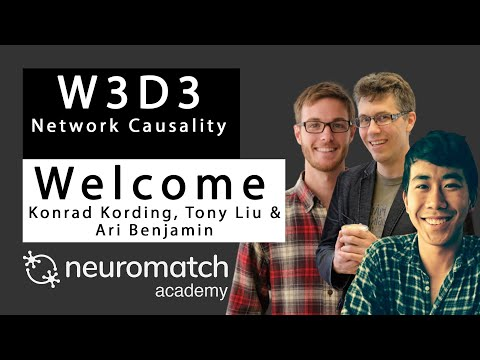

In [12]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="tA2T5ec2v_0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# Summary

In this tutorial, we:

* Explored instrumental variables and how we can use them for causality estimates
* Compared IV estimates to regression estimates

# Advanced Exercise: Exploring instrument strength

Explore how the strength of the instrument $\eta$ affects the quality of estimates with instrumental variables. 

**Hints**
- the code structure from our hidden helper function ``compare_iv_estimate_to_regression`` in Exercise 2 can largely be reused, this time iterating over `etas` instead of `observed_ratio`



In [13]:
n_neurons = 20 # the size of the system
timesteps = 10000
n_trials = 3

etas = [2, 1, 0.5, 0.25, 0.12]
corr_data = np.zeros((n_trials, len(etas)))

for trial in range(n_trials):
    print("Trial {} of {}".format(trial+1, n_trials))
    for j, eta in enumerate(etas):
        ########################################################################
        ## Insert your code here to get IV estimates for different levels of 
        ## instrument strength
        ########################################################################
        # Fill in these and uncomment 
        # A, X, Z = ..., ..., ...
        # iv_V = ...
        # corr_data[trial, j] = ...
        pass
# Visualize IV performance as instrument strength varies, uncomment to run

# corr_mean = corr_data.mean(axis=0)
# corr_std = corr_data.std(axis=0)

# plt.plot(etas, corr_mean)
# plt.fill_between(etas,
#             corr_mean - corr_std,
#             corr_mean + corr_std,
#             alpha=.2)   
# plt.xlim([etas[0], etas[-1]])
# plt.title("IV performance as a function of instrument strength")
# plt.ylabel("Correlation b.t. IV and true connectivity")
# plt.xlabel("Strength of instrument (eta)")
# plt.show()

Trial 1 of 3
Trial 2 of 3
Trial 3 of 3


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D3_NetworkCausality/solutions/W3D3_Tutorial4_Solution_95c7b44e.py)

*Example output:*

<img alt='Solution hint' align='left' width=512 height=406 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D3_NetworkCausality/static/W3D3_Tutorial4_Solution_95c7b44e_3.png>

